In [1]:
# -----------------------------
# 1. Imports
# -----------------------------
import pandas as pd
import numpy as np
from datetime import datetime
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 2. Load dataset
# -----------------------------
data = pd.read_csv(r'D:\MUFG-Hackathon\Backend\Dataset\synthetic_insurance_50k.csv')

In [3]:
# -----------------------------
# 3. Feature Engineering
# -----------------------------
data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'], dayfirst=True)
data['Policy End Date'] = pd.to_datetime(data['Policy End Date'], dayfirst=True)
data['Policy Duration'] = (data['Policy End Date'] - data['Policy Start Date']).dt.days
data['Claim Ratio'] = data['Claim Amount (AUD)'] / data['Annual Premium (AUD)']
data['Premium per Day'] = data['Annual Premium (AUD)'] / data['Policy Duration']

bins = [20,30,40,50,60,70,80]
labels = ['21-30','31-40','41-50','51-60','61-70','71-80']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

data = data.drop(columns=['Policy Start Date','Policy End Date'])

cat_features = ['State','Insurance Type','Claim Status','Payment Frequency','Age Group']
for col in cat_features:
    data[col] = data[col].astype(str).fillna('Unknown')

In [4]:
# -----------------------------
# 4. Predict Risk Score (Regression)
# -----------------------------
X_risk = data.drop(columns=['Risk Score','Product Tier'])
y_risk = data['Risk Score']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

risk_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=50
)

train_pool_risk = Pool(Xr_train, yr_train, cat_features=cat_features)
test_pool_risk = Pool(Xr_test, yr_test, cat_features=cat_features)

risk_model.fit(train_pool_risk, eval_set=test_pool_risk, verbose=50)

yr_pred = risk_model.predict(Xr_test)
print("RMSE on Risk Score prediction:", np.sqrt(mean_squared_error(yr_test, yr_pred)))

0:	learn: 0.1910809	test: 0.1905852	best: 0.1905852 (0)	total: 192ms	remaining: 1m 35s
50:	learn: 0.0697428	test: 0.0697563	best: 0.0697563 (50)	total: 2.81s	remaining: 24.8s
100:	learn: 0.0693578	test: 0.0695586	best: 0.0695586 (100)	total: 5.11s	remaining: 20.2s
150:	learn: 0.0691106	test: 0.0695079	best: 0.0695052 (146)	total: 7.85s	remaining: 18.1s
200:	learn: 0.0688670	test: 0.0694879	best: 0.0694855 (183)	total: 10.9s	remaining: 16.2s
250:	learn: 0.0686696	test: 0.0694929	best: 0.0694855 (183)	total: 13.7s	remaining: 13.5s
300:	learn: 0.0684810	test: 0.0694992	best: 0.0694855 (183)	total: 16.5s	remaining: 10.9s
350:	learn: 0.0682986	test: 0.0695354	best: 0.0694855 (183)	total: 19.4s	remaining: 8.22s
400:	learn: 0.0681385	test: 0.0695447	best: 0.0694855 (183)	total: 22.3s	remaining: 5.51s
450:	learn: 0.0679340	test: 0.0695704	best: 0.0694855 (183)	total: 25.2s	remaining: 2.73s
499:	learn: 0.0677701	test: 0.0695787	best: 0.0694855 (183)	total: 28s	remaining: 0us

bestTest = 0.06948

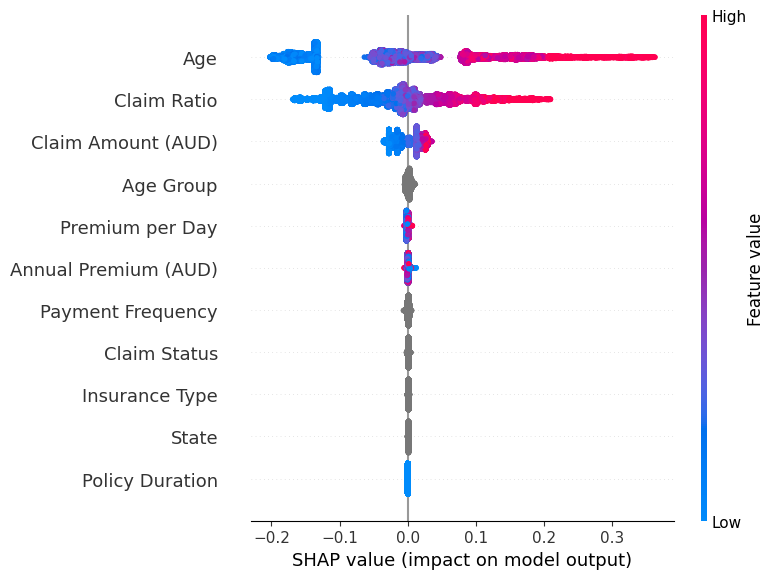

In [5]:
# -----------------------------
# 4a. SHAP Explainable AI for Risk Score
# -----------------------------
risk_explainer = shap.TreeExplainer(risk_model, feature_perturbation="tree_path_dependent")
risk_shap_values = risk_explainer.shap_values(train_pool_risk)

# Visual summary for features
shap.summary_plot(risk_shap_values, Xr_train, feature_names=Xr_train.columns)

In [6]:
# -----------------------------
# 5. Predict Product Tier (Classification)
# -----------------------------
X_full = data.drop(columns=['Product Tier','Risk Score'])
data['Predicted Risk Score'] = risk_model.predict(X_full)

X_tier = data.drop(columns=['Product Tier','Risk Score'])
y_tier = data['Product Tier']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_tier)

Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_tier, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

for col in cat_features:
    Xt_train[col] = Xt_train[col].astype(str).fillna('Unknown')
    Xt_test[col] = Xt_test[col].astype(str).fillna('Unknown')

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42,
    verbose=50
)

train_pool_tier = Pool(Xt_train, yt_train, cat_features=cat_features)
test_pool_tier = Pool(Xt_test, yt_test, cat_features=cat_features)

cat_model.fit(train_pool_tier, eval_set=test_pool_tier, verbose=50)

yt_pred = cat_model.predict(Xt_test).flatten().astype(int)
yt_test_decoded = le_y.inverse_transform(yt_test)
yt_pred_decoded = le_y.inverse_transform(yt_pred)

print("Accuracy for Product Tier:", accuracy_score(yt_test_decoded, yt_pred_decoded))
print("\nClassification Report:\n", classification_report(yt_test_decoded, yt_pred_decoded))

0:	learn: 1.2411198	test: 1.2410021	best: 1.2410021 (0)	total: 110ms	remaining: 54.7s
50:	learn: 0.5080492	test: 0.5087413	best: 0.5087413 (50)	total: 5.95s	remaining: 52.4s
100:	learn: 0.4952542	test: 0.4983904	best: 0.4983904 (100)	total: 12s	remaining: 47.5s
150:	learn: 0.4884749	test: 0.4946043	best: 0.4946043 (150)	total: 18.2s	remaining: 42.1s
200:	learn: 0.4840264	test: 0.4932643	best: 0.4932643 (200)	total: 25.1s	remaining: 37.3s
250:	learn: 0.4797522	test: 0.4925471	best: 0.4925189 (249)	total: 31.3s	remaining: 31s
300:	learn: 0.4758617	test: 0.4918811	best: 0.4917998 (296)	total: 37.3s	remaining: 24.6s
350:	learn: 0.4719076	test: 0.4910924	best: 0.4910597 (326)	total: 43.9s	remaining: 18.6s
400:	learn: 0.4688651	test: 0.4909506	best: 0.4908606 (395)	total: 50.9s	remaining: 12.6s
450:	learn: 0.4653653	test: 0.4908722	best: 0.4907515 (421)	total: 58.4s	remaining: 6.34s
499:	learn: 0.4622038	test: 0.4906273	best: 0.4906273 (499)	total: 1m 4s	remaining: 0us

bestTest = 0.49062729

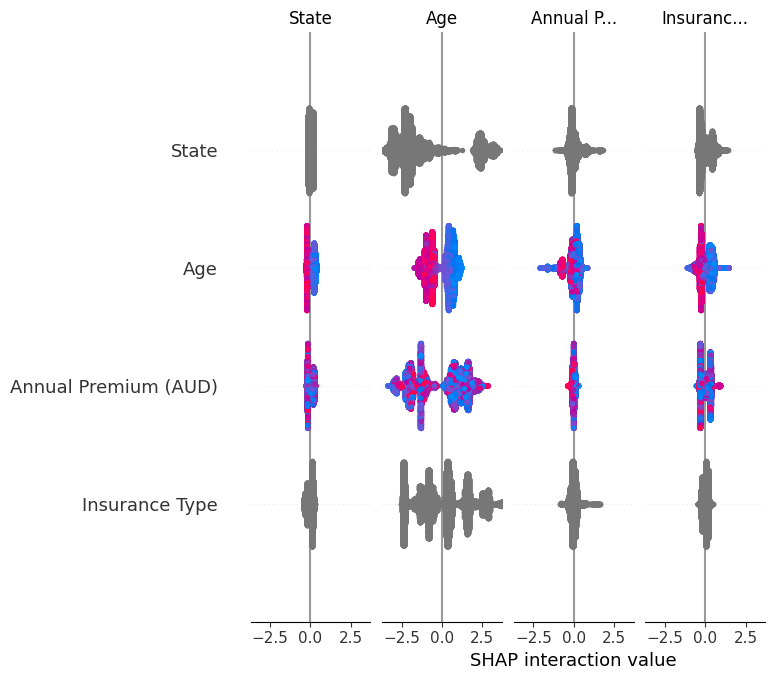

In [7]:
# -----------------------------
# 5a. SHAP Explainable AI for Product Tier
# -----------------------------
tier_explainer = shap.TreeExplainer(cat_model, feature_perturbation="tree_path_dependent")
tier_shap_values = tier_explainer.shap_values(train_pool_tier)

# Visual summary
shap.summary_plot(tier_shap_values, Xt_train, feature_names=Xt_train.columns)

In [12]:
# -----------------------------
# 6. Function to recommend tier for new user with human-readable SHAP explanations
# -----------------------------
def recommend_tier(user_input_dict, top_n=2):
    df = pd.DataFrame([user_input_dict])
    
    # Feature engineering
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'], dayfirst=True)
    df['Policy End Date'] = pd.to_datetime(df['Policy End Date'], dayfirst=True)
    df['Policy Duration'] = (df['Policy End Date'] - df['Policy Start Date']).dt.days
    df['Claim Ratio'] = df['Claim Amount (AUD)'] / df['Annual Premium (AUD)']
    df['Premium per Day'] = df['Annual Premium (AUD)'] / df['Policy Duration']
    
    bins = [20,30,40,50,60,70,80]
    labels = ['21-30','31-40','41-50','51-60','61-70','71-80']
    df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    df = df.drop(columns=['Policy Start Date','Policy End Date'])
    
    for col in cat_features:
        df[col] = df[col].astype(str).fillna('Unknown')
    
    # -----------------------------
    # Predict Risk Score
    # -----------------------------
    df['Predicted Risk Score'] = risk_model.predict(df)
    
    # SHAP for Risk Score
    user_risk_shap = risk_explainer(df)
    shap.force_plot(risk_explainer.expected_value, user_risk_shap.values, df)
    
    # -----------------------------
    # Predict Product Tier probabilities
    # -----------------------------
    proba = cat_model.predict_proba(df)[0]
    top_indices = np.argsort(proba)[::-1][:top_n]
    recommendations = [(le_y.classes_[i], proba[i]) for i in top_indices]
    
    # SHAP for Product Tier (multi-class)
    user_tier_shap = tier_explainer(df)
    
    # -----------------------------
    # Human-readable explanation
    # -----------------------------
    explanation = []
    for tier, p in recommendations:
        # Get SHAP values for this tier
        top_class_idx = le_y.transform([tier])[0]
        shap_vals = user_tier_shap.values[0, :, top_class_idx]
        
        # Top 3 features contributing to prediction
        top_features_idx = np.argsort(np.abs(shap_vals))[::-1][:3]
        top_features = df.columns[top_features_idx]
        contributions = shap_vals[top_features_idx]
        
        # Make human-readable
        reasons = []
        for f, c in zip(top_features, contributions):
            direction = "increases" if c > 0 else "decreases"
            reasons.append(f"{f} {direction} likelihood of selecting '{tier}'")
        
        reason_text = "; ".join(reasons)
        
        explanation.append(
            f"Recommended Tier: '{tier}' (prob={p:.2f})\n"
            f"Based on your predicted risk score ({df['Predicted Risk Score'][0]:.2f}) and premium "
            f"({user_input_dict['Annual Premium (AUD)']} AUD). Key factors influencing this recommendation: {reason_text}."
        )
    
    return recommendations, explanation


In [15]:
# -----------------------------
# 7. Example for new user (formatted)
# -----------------------------
new_user = {
    'Age': 21,
    'State': 'SA',
    'Insurance Type': 'Health',
    'Annual Premium (AUD)': 2500,
    'Claim Amount (AUD)': 12000,
    'Claim Status': 'Approved',
    'Payment Frequency': 'Monthly',
    'Policy Start Date': '01-01-2024',
    'Policy End Date': '31-12-2024'
}

recommendations, explanation = recommend_tier(new_user, top_n=2)

# Print nicely
print("Main Recommendation:")
print(f"- {recommendations[0][0]} (prob={recommendations[0][1]:.2f})")
print(f"  Explanation: {explanation[0]}\n")

print("Alternative Option:")
print(f"- {recommendations[1][0]} (prob={recommendations[1][1]:.2f})")
print(f"  Explanation: {explanation[1]}")


Main Recommendation:
- Standard (prob=0.57)
  Explanation: Recommended Tier: 'Standard' (prob=0.57)
Based on your predicted risk score (0.48) and premium (2500 AUD). Key factors influencing this recommendation: Payment Frequency increases likelihood of selecting 'Standard'; Age Group increases likelihood of selecting 'Standard'; Age increases likelihood of selecting 'Standard'.

Alternative Option:
- Basic (prob=0.43)
  Explanation: Recommended Tier: 'Basic' (prob=0.43)
Based on your predicted risk score (0.48) and premium (2500 AUD). Key factors influencing this recommendation: Payment Frequency increases likelihood of selecting 'Basic'; Age Group increases likelihood of selecting 'Basic'; Age increases likelihood of selecting 'Basic'.
